# Predict Patient No-Show

### Problem
A binary classification problem to predict the label of the No-Show class. Labels = {Yes, No}

### Dataset
110527 (88208 Show / 22319 No-show) patients with appointments ranging in date from 4/29/2016 - 6/07/2016

### Features
(By Rank)
1. (Tie) Alcoholism - Has patient been diagnosed with Alcoholism? 0 - No / 1 - Yes
2. (Tie) Diabetes - Has patient been diagnosed with Diabetes? 0 - No / 1 - Yes
3. (Tie) Hypertension - Has patient been diagnosed with Hypertension? 0 - No / 1 - Yes
4. (Tie) NoShowRatio - Ratio of number of missed appointments to number of total appointments per patient
5. (Tie) NumAppts - Total number of appointments per patient
6. (Tie) SMS - Did the patient receive a confirmation text? 0 - No / 1 - Yes
7. (Tie) WaitTime - Number of days from when appointment scheduled to appointment. 
8. Scholarship - Did the patient receive a scholarship? 0 - No / 1 - Yes
9. SumNoShow - How many appointments has this patient missed? 
10. DayWeek - What day of week was the appointment? 0 (Monday) - 6 (Sunday)
11. DayMonth - What day of month was the appointment? 1 - 31
12. Gender - What gender was the patient? 1/M - Male, 0/F - Female
13. Neighborhood - In what neighborhood did the appointment take place? 0 - 80
14. Handicap - What level of handicap does this patient have? 1 - 4
15. Age - What is the age of the patient? 0 - 115


### Target
NoShow - did the patient miss their appointment? 0 - No / 1 - Yes


### Results:
Using all 15 features:

** Model: Accuracy (Std) **

- LR:  	0.907 (+/- 0.063)
- LDA:	0.900 (+/- 0.064)
- KNN:	0.799 (+/- 0.030)
- CART:	0.889 (+/- 0.078)
- NB: 	0.888 (+/- 0.068)

Using only top 7 features:

** Model: Accuracy (Std) **

- LR:	0.908 (+/- 0.061)
- LDA:	0.897 (+/- 0.061)
- KNN:	0.896 (+/- 0.068)
- CART:	0.908 (+/- 0.062)
- NB:	0.891 (+/- 0.060)


### Literature Review
- [A probabilistic model for predicting the probability of no-show in hospital appointments](https://link.springer.com/article/10.1007/s10729-011-9148-9)
- [Machine-Learning-Based No Show Prediction in
Outpatient Visits](http://www.ijimai.org/journal/sites/default/files/files/2017/03/ijimai_4_7_4_pdf_11885.pdf)
- [Patient No-Show Predictive Model Development using Multiple Data Sources for an Effective Overbooking Approach](https://www.thieme-connect.com/products/ejournals/abstract/10.4338/ACI-2014-04-RA-0026)
- [Predicting appointment misses in hospitals using data analytics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5427184/)


In [63]:
import pandas as pd
import numpy as np
import time
from datetime import datetime, date
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

In [2]:
#Read in data
data = pd.read_csv("/Users/giovannagraciani/Desktop/555/KaggleV2-May-2016.csv", header=0)
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Data Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# Convert PatientId to int64
data['PatientId'] = data['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay to 'datetime64[ns]'
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay']).dt.date.astype('datetime64[ns]')
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay']).dt.date.astype('datetime64[ns]')

# Correct spelling
data = data.rename(columns={'Hipertension': 'Hypertension', 'PatientId':'PatientID','Handcap': 'Handicap', 'SMS_received': 'SMS', 'No-show': 'NoShow'})

In [5]:
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,NoShow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data['Neighbourhood'] = le.fit_transform(data['Neighbourhood'])
data['NoShow'] = le.fit_transform(data['NoShow'])

#data.info()

# Feature Exploration

### Missed Appts & NoShow Ratio

In [7]:
# Are there patients with multiple visits? (Yes)
patient_count = data.groupby('PatientID').size().reset_index(name='NumAppts')

In [8]:
data = pd.merge(data, patient_count, on='PatientID', how='right')

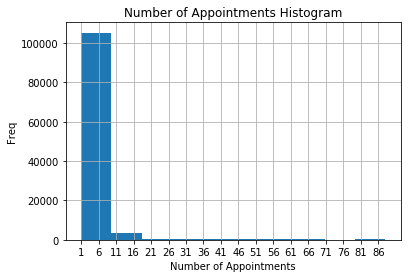

In [9]:
data.NumAppts.hist()
plt.title('Number of Appointments Histogram')
plt.xticks(np.arange(min(data.NumAppts), max(data.NumAppts)+1, 5.0))
plt.xlabel('Number of Appointments')
plt.ylabel('Freq')
plt.show()

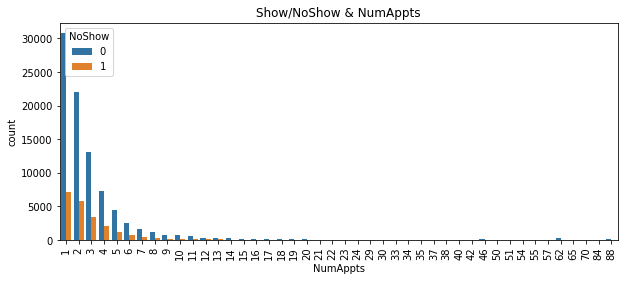

In [10]:
#Appears strongly correlated
plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
ns = sns.countplot(x=data.NumAppts, hue=data.NoShow)
ns.set_title("Show/NoShow & NumAppts")
plt.show()

In [11]:
num_missed = data.groupby('PatientID')['NoShow'].agg('sum').rename('SumNoShow').reset_index()

In [12]:
data = pd.merge(data, num_missed, on='PatientID', how='right')

In [13]:
data['NoShowRatio'] = (data['SumNoShow'] / data['NumAppts'])

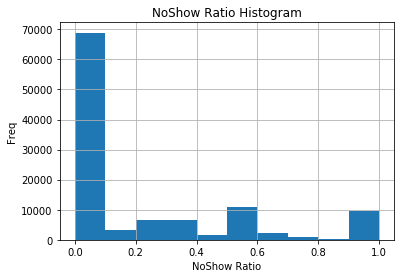

In [14]:
data.NoShowRatio.hist()
plt.title('NoShow Ratio Histogram')
plt.xlabel('NoShow Ratio')
plt.ylabel('Freq')
plt.show()

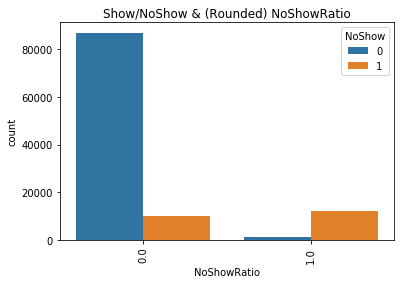

In [15]:
#plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
plt.xticks(np.arange(0, 1, 0.5))
ns = sns.countplot(x=round(data.NoShowRatio), hue=data.NoShow)
ns.set_title("Show/NoShow & (Rounded) NoShowRatio")
plt.show()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 17 columns):
PatientID         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null int64
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null int64
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS               110527 non-null int64
NoShow            110527 non-null int64
NumAppts          110527 non-null int64
SumNoShow         110527 non-null int64
NoShowRatio       110527 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(14)
memory usage: 20.2 MB


### Overall

In [17]:
data.groupby('NoShow').count()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,NumAppts,SumNoShow,NoShowRatio
NoShow,,,,,,,,,,,,,,,,
0,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208
1,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319


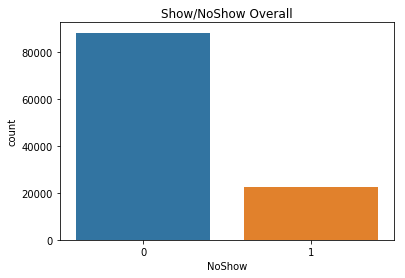

In [18]:
ns = sns.countplot(x=data.NoShow, data=data)
ns.set_title("Show/NoShow Overall")
plt.show()

In [19]:
print("No-show: ", round(22319/(88208 + 22319), 4))

No-show:  0.2019


### Gender

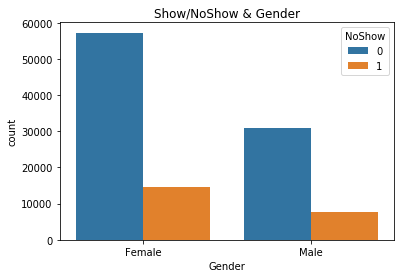

In [20]:
ns = sns.countplot(x=data.Gender, hue=data.NoShow)
ns.set_title("Show/NoShow & Gender")
x_ticks_labels=['Female', 'Male']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### Age

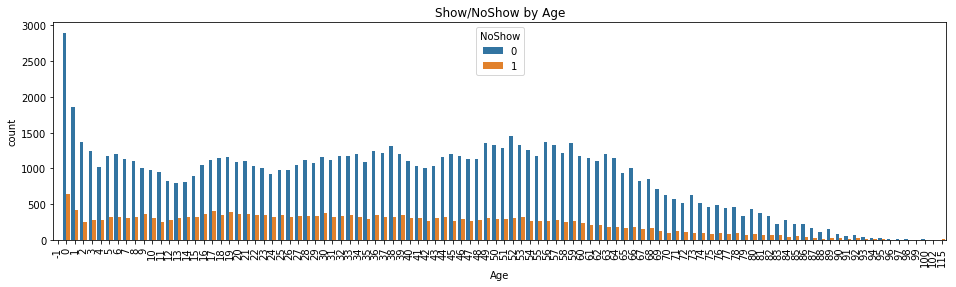

In [21]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ns = sns.countplot(x=data.Age, hue=data.NoShow)
ns.set_title("Show/NoShow by Age")
plt.show()

### WaitTime

In [22]:
#Calculate distance from when appointment scheduled to appointment da)
data['WaitTime'] =abs((data['AppointmentDay'] - data['ScheduledDay']).dt.days)
data['WaitTime'].max()

179

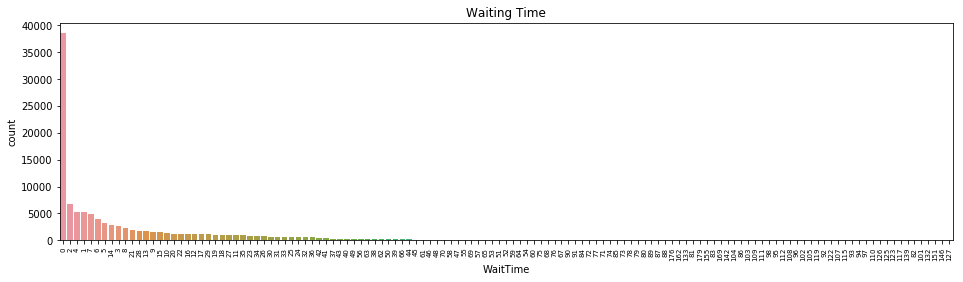

In [23]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=data.WaitTime, order=data.WaitTime.value_counts().index)
ax.set_title("Waiting Time")
plt.xticks(rotation=90,size=7)
plt.show()

### Scholarship	

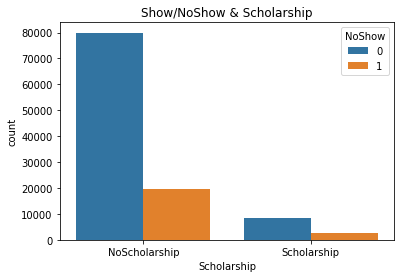

In [24]:
ns = sns.countplot(x=data.Scholarship, hue=data.NoShow)
ns.set_title("Show/NoShow & Scholarship")
x_ticks_labels=['NoScholarship', 'Scholarship']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### Hypertension

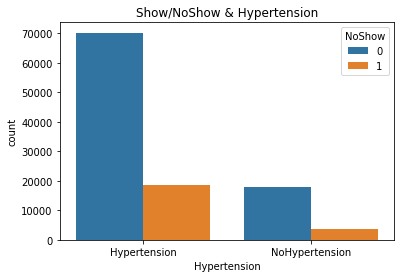

In [25]:
ns = sns.countplot(x=data.Hypertension, hue=data.NoShow)
ns.set_title("Show/NoShow & Hypertension")
x_ticks_labels=['Hypertension', 'NoHypertension']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### Diabetes 

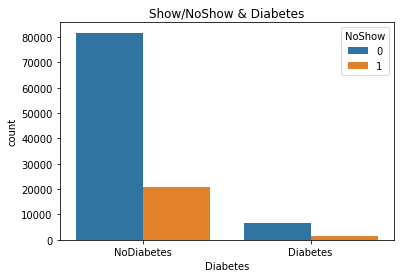

In [26]:
ns = sns.countplot(x=data.Diabetes, hue=data.NoShow)
ns.set_title("Show/NoShow & Diabetes")
x_ticks_labels=['NoDiabetes', 'Diabetes']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### Alcoholism 

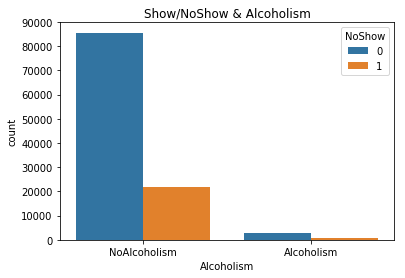

In [27]:
ns = sns.countplot(x=data.Alcoholism, hue=data.NoShow)
ns.set_title("Show/NoShow & Alcoholism")
x_ticks_labels=['NoAlcoholism', 'Alcoholism']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### Handicap

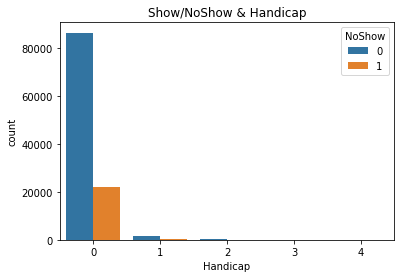

In [28]:
ns = sns.countplot(x=data.Handicap, hue=data.NoShow)
ns.set_title("Show/NoShow & Handicap")
plt.show()

### SMS

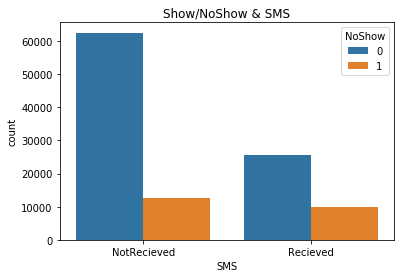

In [29]:
ns = sns.countplot(x=data.SMS, hue=data.NoShow)
ns.set_title("Show/NoShow & SMS")
x_ticks_labels=['NotRecieved', 'Recieved']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### DayWeek

In [30]:
data['DayWeek'] = pd.to_datetime(data['AppointmentDay']).dt.weekday

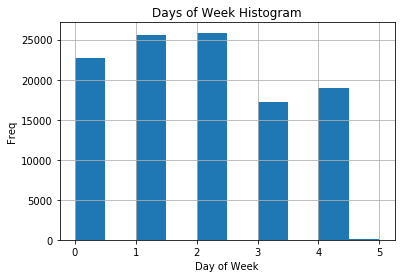

In [31]:
data.DayWeek.hist()
plt.title('Days of Week Histogram')
plt.xlabel('Day of Week')
plt.ylabel('Freq')
plt.show()

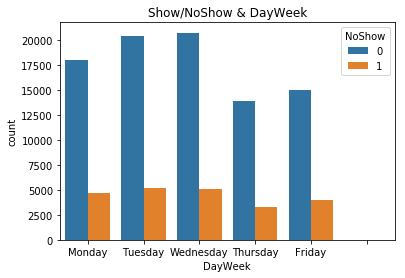

In [32]:
ns = sns.countplot(x=data.DayWeek, hue=data.NoShow)
ns.set_title("Show/NoShow & DayWeek")
x_ticks_labels=['Monday', 'Tuesday','Wednesday','Thursday','Friday']#,'Saturday','Sunday']
ns.set_xticklabels(x_ticks_labels)
plt.show()

### DayMonth

In [33]:
data['DayMonth'] = pd.to_datetime(data['AppointmentDay']).dt.day

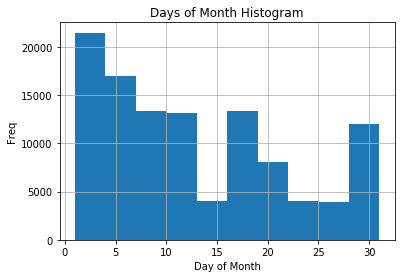

In [34]:
data.DayMonth.hist()
plt.title('Days of Month Histogram')
plt.xlabel('Day of Month')
plt.ylabel('Freq')
plt.show()

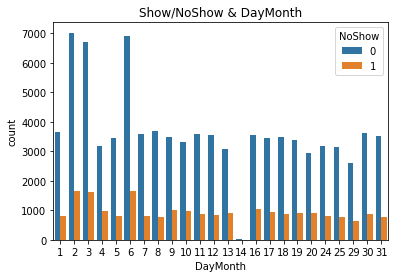

In [35]:
ns = sns.countplot(x=data.DayMonth, hue=data.NoShow)
ns.set_title("Show/NoShow & DayMonth")
plt.show()

In [36]:
#Will eventually convert all features to 
y = data['NoShow']
X = data.drop(['PatientID', 'AppointmentID','ScheduledDay','AppointmentDay','NoShow'], axis=1)

In [37]:
X.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS,NumAppts,SumNoShow,NoShowRatio,WaitTime,DayWeek,DayMonth
0,0,62,39,0,1,0,0,0,0,2,0,0.0,0,4,29
1,0,62,39,0,1,0,0,0,0,2,0,0.0,0,4,29
2,1,56,39,0,0,0,0,0,0,2,0,0.0,0,4,29
3,1,56,39,0,0,0,0,0,0,2,0,0.0,0,4,29
4,0,62,45,0,0,0,0,0,0,2,0,0.0,0,4,29


# Feature Selection
"the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features."
- [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)


In [38]:
names = X.columns.values
logreg = LogisticRegression()
rfe=RFE(logreg)
rfe=rfe.fit(X, y)
print("Features sorted by rank:")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_),names)))

Features sorted by rank:
[(1, 'Alcoholism'), (1, 'Diabetes'), (1, 'Hypertension'), (1, 'NoShowRatio'), (1, 'NumAppts'), (1, 'SMS'), (1, 'WaitTime'), (2, 'Scholarship'), (3, 'SumNoShow'), (4, 'DayWeek'), (5, 'Handicap'), (6, 'DayMonth'), (7, 'Gender'), (8, 'Neighbourhood'), (9, 'Age')]


# Try a bunch of models to find the best one

Credit for the following 3 cells of code: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [39]:
models = []
results = []
names = []
scoring = 'accuracy'
seed = 7
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [40]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)

LR:	0.907 (+/- 0.063)
LDA:	0.900 (+/- 0.064)
KNN:	0.799 (+/- 0.030)
CART:	0.889 (+/- 0.078)
NB:	0.888 (+/- 0.068)


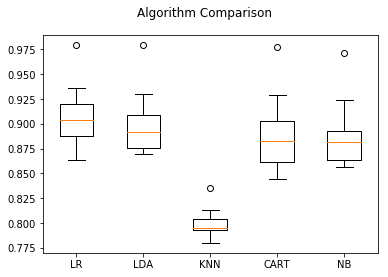

In [41]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Try only using top features

In [42]:
X2 = data.drop(['PatientID', 'AppointmentID','ScheduledDay','AppointmentDay','NoShow','SumNoShow', 'Scholarship', 'DayWeek', 'DayMonth', 'Gender', 'Neighbourhood', 'Handicap','Age'], axis=1)
X2.head()

,Hypertension,Diabetes,Alcoholism,SMS,NumAppts,NoShowRatio,WaitTime
0,1,0,0,0,2,0.0,0
1,1,0,0,0,2,0.0,0
2,0,0,0,0,2,0.0,0
3,0,0,0,0,2,0.0,0
4,0,0,0,0,2,0.0,0


In [70]:
results2 = [] 

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X2, y, cv=kfold, scoring=scoring)
    results2.append(cv_results)
    names.append(name)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)

LR:	0.908 (+/- 0.061)
LDA:	0.897 (+/- 0.061)
KNN:	0.896 (+/- 0.068)
CART:	0.908 (+/- 0.062)
NB:	0.891 (+/- 0.060)


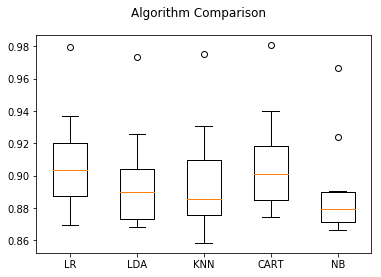

In [71]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names)
plt.show()

# Fit "Best" Model (highest accuracy):

## Train/Test Data Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3)

## Fit

In [59]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

## Predict

In [83]:
#Will use this prediction
y_predict = logreg.predict_proba(X_test)
my_list = map(lambda x: x[1], y_predict)
y_pred = pd.Series(my_list).round()

# Accuracy

In [84]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.910


# Confusion Matrix

In [85]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",confusion)

#Sanity check
print("\nAccuracy: ",round((25433+4733)/33159,3))

Confusion matrix:
 [[25433  1011]
 [ 1982  4733]]

Accuracy:  0.91


# Classification Report

In [86]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94     26444
          1       0.82      0.70      0.76      6715

avg / total       0.91      0.91      0.91     33159



# ROC Curve

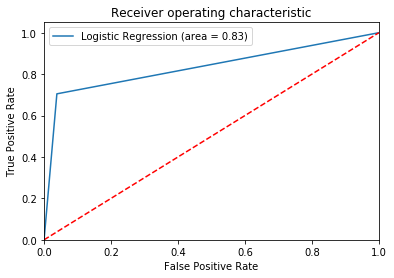

In [87]:
logit_roc_auc = roc_auc_score(y_test, y_pred) #pos_label='Yes')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()

# AUC

In [88]:
print(logit_roc_auc)

0.8333040878303304


# Submission

In [89]:
# Format 1 - Predictions encoded as 0 (No NoShow) or 1 (Yes NoShow) 
np.savetxt('Team1_NoShow_Submission_01.csv', y_pred, delimiter=',',header='Prediction')

In [90]:
view_submission_01 = pd.read_csv('Team1_NoShow_Submission_01.csv', header=0)
print(view_submission_01.head())

   # Prediction
0           0.0
1           1.0
2           0.0
3           0.0
4           0.0


In [91]:
# Format 2 - Predictions either No or Yes 
y_pred = y_pred.apply(lambda x: 'No' if x==0 else 'Yes')
np.savetxt('Team1_NoShow_Submission_NoYes.csv', y_pred , delimiter=',',fmt="%s",header='Prediction')

In [92]:
view_submission_NoYes = pd.read_csv('Team1_NoShow_Submission_NoYes.csv', header=0)
print(view_submission_NoYes.head())

  # Prediction
0           No
1          Yes
2           No
3           No
4           No
